# Part IV -  ML For Interpersonal Physical Alignment
#####  @ Haim Goldfisher

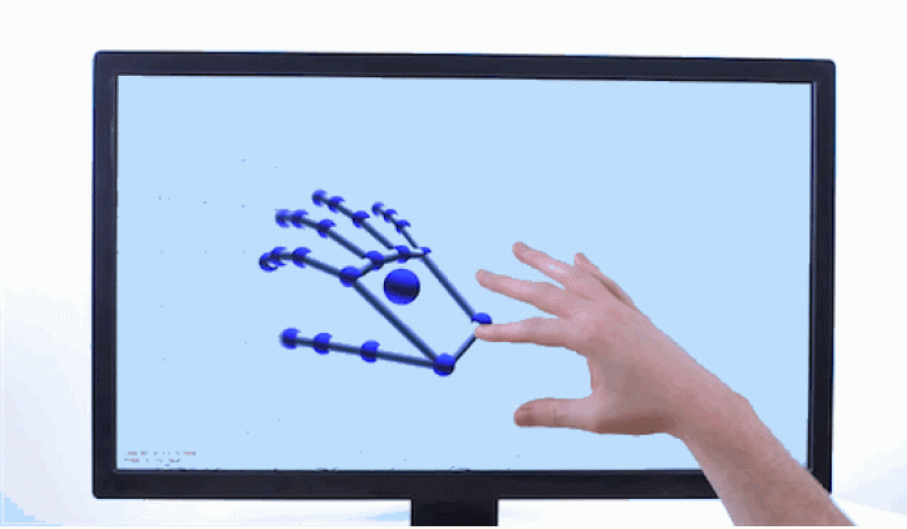

In [26]:
import cv2 # openCv
from os import listdir
from os.path import isfile, join
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#import warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Data Preprocessing:

from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, roc_auc_score, accuracy_score

# Models:

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

# A model that I learned by myself: CatBoost + Plotly

from catboost import CatBoostClassifier
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px

# Clustering:

from sklearn.cluster import KMeans

# PCA:

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA

# Scaling:

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Cross Validation:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## Brief Summary:

The purpose of the work is to classify between three different situations in the way people communicate with each other:
- The first is Spontaneous (autonomous) situation in which two people move their hands freely in front of each other.
- The second is a synchronous movement in which the two people move their hands together. 
- The third is a movement in position own (alone). Where only one side moves the hands.
The idea is to look at the patterns of the hands and try to deduce from them whether it is a situation alone, spontaneous or synchronous. (GOOGLE TRANSLATE)

The experiment is based on synchronization between two people. That is, they both "transmit on the same wave" so that no one is leading this synchronization. In this case the argument is that there is not one "brain" of the two that leads but two brains of two people uniting into a spring of cooperation that is supposedly above both of them, which controls their movements in the synchronization process.

The experiment uses a system that captures the position of a person's hands. The system knows where the hand is. The experiment places two people facing each other. The experiment operation tells them to move their hands in front of each other spontaneously. He then asks them to be in sync (the process causes both parties to try to be in sync). People begin to perceive each other in order to understand the other side (there must be no imitation of one side, otherwise it does not work). We have three situations: alone, spontaneous in front of another person and in sync with another person.

Assumption of the experiment: The felt state will necessarily be different from the spontaneous state. That is, an experience of looking at another person, the connection between them automatically changes the movement of the two people (as long as they do not have autism). Also, the distance between the two people should be taken into account, because a person alone will move freely when there is no person next to him that he can hurt. In contrast, people who stand relatively close will inevitably move in more measured movements so as not to accidentally hurt each other.

Note, the literature defines synchronization as a product of a velocity vector. When people are in sync, they have the same velocity vector. The above experiment examines the definition of synchronization as the location of the two entities to each other at a given time.

## A Little Bit About The Data:

First of all, let's note that this is a classification problem with three labels: alone, spontaneous and synchronized.

Each CSV file belongs to one of the three labels, and is associated with one of the people who performed the experiment. The data frame of each experiment contains 22 features:

1. Time -
2. Frame ID -
3. Hand Type (right/left) -
4. number hands (1/2) -
5. ,6,7.  Position X,Y,Z -
8. ,9,10. Velocity X,Y,Z -
11. Pitch -
12. Roll -
13. Yaw -
14. ,15,16. Wrist Pos X,Y,Z -
17. ,18,19. Elbow pos X,Y,Z -
20. Grab Strenth -
21. Grab Angle -
22. Pinch Strength -

The task: to take the data, arrange it using PANDAS, and then produce an optimal model that given the hand position, we can identify in which one of the three possibilities the person was: alone, spontaneous and synchronized.

## Strategy:

We would like to work with TimeSeries to classify the variance during the time. Moreover, we know that 

Work only with training data. Do not touch on validation during model preparation but only at the prediction stage.
We have in the experiment 9 people who each have data depending on the people they were in front of (maybe there is a difference between the people who were in front of them or their order).
If both hands do not appear at the same time - not correct. (Should be both right and left for all time \ ID ie time \ ID must appear twice, otherwise it must be removed).
Usually a second recording is better because the person has already gotten used to the state of the experiment.
Please note, TRAINING is the first 40 seconds, TESTING is the last 20 seconds. This is obligatory from reality because there is a clear correlation between what happened before the moment and what will happen or happened a moment before or after. That is, the position of the hand in one frame and in the frame after it will always be very close.
It is recommended to take a maximum of 4 frames per second (if you want to get rid of a certain part of the data, you can for example take two samples from the data every second, assuming it does not go so far during the second - if the download does not hurt the model, but no more than 4 frames per second).
Recommended way of working - build a model for one person. Then try it on another person and then fix so that the model "catches" the two people and so on.
The conclusion of the experiment: The position vector exceeds the velocity vector. Synchronization is expressed in the need of the two people to find synchronization at the level of their location opposite each other, and not the same speed of movement.

## Datasets:

In [27]:
def upload(path):
    folders = glob.glob(path + "/*")
    data = []
    labels = ["Alone", "Spontan", "Sync"]
    new_features = ['Time', ' Position X_left', ' Position Y_left', ' Position Z_left', ' Velocity X_left', ' Velocity Y_left',
       ' Velocity Z_left', ' Pitch_left', ' Roll_left', ' Yaw_left', ' Wrist Pos X_left',
       ' Wrist Pos Y_left', ' Wrist Pos Z_left', ' Elbow Pos X_left', ' Elbow Pos Y_left',
       ' Elbow Pos Z_left', ' Grab Strength_left', ' Grab Angle_left', ' Pinch Strength_left', 'Time_right', ' Position X_right',
       ' Position Y_right', ' Position Z_right', ' Velocity X_right', ' Velocity Y_right',
       ' Velocity Z_right', ' Pitch_right', ' Roll_right', ' Yaw_right', ' Wrist Pos X_right',
       ' Wrist Pos Y_right', ' Wrist Pos Z_right', ' Elbow Pos X_right', ' Elbow Pos Y_right',
       ' Elbow Pos Z_right', ' Grab Strength_right', ' Grab Angle_right', ' Pinch Strength_right']
    for folder_name in folders:
        files = glob.glob(folder_name + "/*.csv")
        for filename in files:
            df = pd.read_csv(filename, index_col=None, header=0)
            for label in labels:
                if label in filename:
                    df["Label"] = label
                    if "Train"  in folder_name:
                        tester = folder_name.split('g')[1][1:] # for train df
                    else: 
                        tester = folder_name.split('n')[4][1:] # for validation df
                    df["Name"] = tester
                    df = (df[df["Time"] > (df["Time"][0]+7)]) # remove the first 7 sec from each test
            data.append(df)
    result = pd.concat(data, axis=0, ignore_index=True) # concat all data frames into one 
    return result

In [28]:
path = "C:\Haim\Anaconda\Experiment\Training"
df_train = upload(path)

In [29]:
df_train["Time"] 

0          71.41422
1          71.41422
2          71.43108
3          71.43108
4          71.44753
            ...    
300392    856.26310
300393    856.29580
300394    856.29580
300395    856.32950
300396    856.32950
Name: Time, Length: 300397, dtype: float64

In [34]:
df_train.groupby('Label').count()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength,Name
Label,,,,,,,,,,,,,,,,,,,,,
Alone,57311,57311,57311,57311,57311,57311,57311,57311,57311,57311,...,57311,57311,57311,57311,57311,57311,57311,57311,57311,57311
Spontan,122015,122015,122015,122015,122015,122015,122015,122015,122015,122015,...,122015,122015,122015,122015,122015,122015,122015,122015,122015,122015
Sync,121071,121071,121071,121071,121071,121071,121071,121071,121071,121071,...,121071,121071,121071,121071,121071,121071,121071,121071,121071,121071


AttributeError: 'Series' object has no attribute 'Alone'

In [108]:
path = "C:\Haim\Anaconda\Experiment\Validation"
df_test = upload(path)

In [109]:
df_test

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength,Label,Name
0,452.3260,53462,right,2,122.72030,143.1381,-16.59749,-46.56372,-111.87010,31.127210,...,117.8634,35.15458,345.4367,-2.931040,148.5701,0.0,0.330704,0.0,Spontan,Itiel Lab
1,452.3260,53462,left,2,-118.21520,174.2778,12.79905,37.16520,22.34652,-4.754824,...,165.4350,36.37275,-386.2074,105.699100,163.8214,0.0,1.236088,0.0,Spontan,Itiel Lab
2,452.3426,53464,right,2,121.43890,141.2153,-15.97054,-76.48299,-112.58460,43.553070,...,116.6887,36.01273,351.4953,2.517474,144.3689,0.0,0.289469,0.0,Spontan,Itiel Lab
3,452.3426,53464,left,2,-118.15110,175.4062,12.79716,-14.95814,79.26344,6.301003,...,165.9130,36.04567,-385.9128,91.015520,155.7026,0.0,1.183778,0.0,Spontan,Itiel Lab
4,452.3592,53466,right,2,120.95080,140.7172,-15.25829,-23.72920,-20.72354,42.888210,...,118.0079,36.46207,356.2715,7.016507,141.2383,0.0,0.294321,0.0,Spontan,Itiel Lab
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81523,998.8158,66221,left,2,-96.74767,323.8981,76.98316,27.14988,185.62180,33.741870,...,267.8716,68.90888,-298.0420,57.523140,124.0967,0.0,0.075099,0.0,Sync,Oded Medi
81524,998.8495,66224,right,2,111.83100,324.5124,102.83410,86.42312,119.68330,-13.673710,...,269.7217,103.07490,340.7914,72.963470,121.5707,0.0,0.024162,0.0,Sync,Oded Medi
81525,998.8495,66224,left,2,-95.67720,329.8123,78.13316,47.37696,118.31670,24.152470,...,273.4537,69.90453,-300.8497,65.109990,120.6967,0.0,0.029208,0.0,Sync,Oded Medi
81526,998.8855,66227,right,2,113.80260,325.5213,101.48600,54.98372,11.75017,-37.260060,...,270.7919,101.25900,344.8011,75.978220,121.1411,0.0,0.025365,0.0,Sync,Oded Medi


## Explore the data: